In [1]:
import tensorflow as tf
import numpy as np
import matplotlib as plt
import konlpy
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import urllib.request
from konlpy.tag import Okt
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

print(tf.__version__)
print(np.__version__)
print(konlpy.__version__)

2.6.0
1.21.4
0.5.2


## 데이터 다운로드

In [15]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt")

('ratings_test.txt', <http.client.HTTPMessage at 0x7f6649eeeb50>)

In [27]:
train_data = pd.read_table('ratings_train.txt')
test_data = pd.read_table('ratings_test.txt')


In [28]:
print('훈련용 리뷰 개수 :',len(train_data))
print('테스트용 리뷰 개수:', len(test_data))

훈련용 리뷰 개수 : 150000
테스트용 리뷰 개수: 50000


In [29]:
train_data[:10]

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1
5,5403919,막 걸음마 뗀 3세부터 초등학교 1학년생인 8살용영화.ㅋㅋㅋ...별반개도 아까움.,0
6,7797314,원작의 긴장감을 제대로 살려내지못했다.,0
7,9443947,별 반개도 아깝다 욕나온다 이응경 길용우 연기생활이몇년인지..정말 발로해도 그것보단...,0
8,7156791,액션이 없는데도 재미 있는 몇안되는 영화,1
9,5912145,왜케 평점이 낮은건데? 꽤 볼만한데.. 헐리우드식 화려함에만 너무 길들여져 있나?,1


시간이 오래 걸려서 일부 텍스트 데이터만 사용

## 데이터 전처리

- 중복값, 결측치 제거
- 한글만 남기기
- 띄어쓰기 고치기
- 형태소 분석
- 한글자, 불용어 제거
- 최소 횟수 이하 단어 제거

In [30]:
train_data['document'].nunique(), train_data['label'].nunique()

(146182, 2)

전체 50000개 데이터 중 중복 제거한 샘플 49120개, label은 긍부정 2종류

In [31]:
# 중복 샘플 제거
train_data.drop_duplicates(subset=['document'], inplace=True)
print('총 샘플의 수 :',len(train_data))


총 샘플의 수 : 146183


In [32]:
# 결측치 확인
train_data.isnull().sum()

id          0
document    1
label       0
dtype: int64

In [33]:
train_data = train_data.dropna()
print(train_data.isnull().sum())

id          0
document    0
label       0
dtype: int64


In [34]:
# 인덱스 재배치
train_data = train_data.reset_index(drop=True)

In [35]:
# 한글만 남기기
import re
def extract_word(text):
    hangul = re.compile('[^가-힣]') 
    result = hangul.sub(' ', text) 
    return result

In [25]:
train_data[train_data['document']  == ""]

,id,document,label


In [36]:
train_data['document'] = train_data['document'].apply(lambda x:extract_word(x))


In [27]:
! pip install git+https://github.com/ssut/py-hanspell.git


  Cloning https://github.com/ssut/py-hanspell.git to /tmp/pip-req-build-o5vkmz8r
  Running command git clone --filter=blob:none -q https://github.com/ssut/py-hanspell.git /tmp/pip-req-build-o5vkmz8r
  Resolved https://github.com/ssut/py-hanspell.git to commit fdc6ca50c19f1c85971437a072d89d4e5ce024b8
  Preparing metadata (setup.py) ... done


In [ ]:

# from hanspell import spell_checker

# for i in range(len(train_data)):
#     spelled_sent = spell_checker.check(train_data['document'][i])
#     hanspell_sent = spelled_sent.checked
#     train_data.loc[i, 'document'] = hanspell_sent
    
#     if i%100 == 0:
#         print(f'{i}번째 문장 완료!')

# print(train_data[:10])


In [40]:
train_data.to_csv('all_data.txt', sep='\t', index=False)
train_data.to_csv('all_data.csv', sep='\t', index=False)

In [41]:
train_data = pd.read_csv('all_data.csv', sep='\t')
train_data

,id,document,label
0,9976970,아 더빙 진짜 짜증 나네요 목소리,0
1,3819312,흠 포스터 보고 초등학생영화 줄 오버 연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다 평점 조정,0
4,6483659,사이먼 페그의 익살스러운 연기가 돋보였던 영화 스파이더맨에서 늙어 보이기만 했던 커...,1
...,...,...,...
146177,6222902,인간이 문제지 소는 뭔죄인가,0
146178,8549745,평점이 너무 낮아서,1
146179,9311800,이게 뭐요 한국인은 거들먹거리고 필리핀 혼혈은 착하다,0
146180,2376369,청춘 영화의 최고봉 방황과 우울했던 날들의 자화상,1


### 데이터 분포 확인

   label  count
0      0  73342
1      1  72840


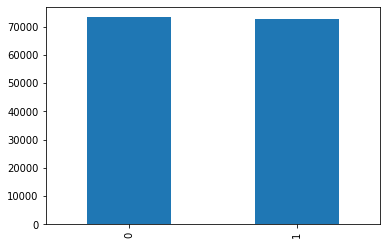

In [42]:
# 라벨 분포 확인
train_data['label'].value_counts().plot(kind = 'bar')
print(train_data.groupby('label').size().reset_index(name = 'count'))

문장의 최단 길이: 1
문장의 최장 길이: 146
문장의 평균 길이: 35
Data Size: 146182


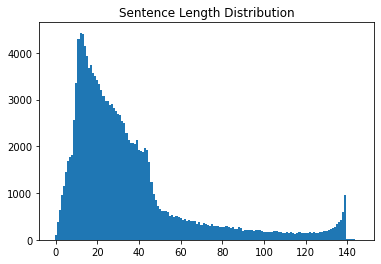

In [43]:
min_len = 999
max_len = 0
sum_len = 0

for sen in train_data['document']:
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(train_data))

sentence_length = np.zeros((max_len), dtype=int)

for sen in train_data['document']:
    sentence_length[len(sen)-1] += 1

    
print("Data Size:", len(train_data))
plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

In [44]:
def check_sentence_with_length(raw, length):
    count = 0
    
    for sen in raw:
        if len(sen) == length:
            print(sen)
            count += 1
            if count > 100: return


In [45]:
check_sentence_with_length(train_data['document'], 25)

어린나이에 봤음에도 꽤나 좋아했던 로맨틱코미디
신나는 흑인음악과 아이스 큐브 뿐 남는게 없다
네놈을 살려두기엔 쌀이 아까워  세기의 명대사
지금 이거 티비로 돈내고 보고있는 내가한심하다
잊을 수 없는 안개낀 워터루 다리와 마스코트 
이 영화는 최고다  그냥 최고야 그런 줄 알아
진짜 어마어마한 여운을 주는 멜로 영화에요  
역시 효느    역시 재밌다    재탕중   
평생 기억할만한 영화 정상적인 소재는 아니지만
배우들 연기력이 아깝다  별 한 개도 아깝다 
몸매 베드신 보기좋다고 한사람은 영화 안본사람
엄청나게 기대를 하고 본게 아니라 괜찮았던듯 
설득력없는 꼴통페미니즘  페미나치적인 마인드 
힘알이 하나 없는 주인공들  맥이 다 빠진다 
이게    영화냐    년도영화냐  쓰래기들아
너무 구식으로 웃길려고 함  보는 내내 지겨움
퀸틴 타란티노의 포룸을 어줍잖게 패러디한 졸작
이영화정말별로다   니콜라스케이지연기만볼만함 
그냥 여자들의 이중성일뿐   아이구 의미없다 
제목부터 심상치 않은 영화 옥주현나오는줄알았다
전 이평점에   느면 어케되는지 궁금해서 해봄
물체가 움직이거나 어떤 일이 진행되는 빠르기 
보고 감동의눈물을 흘렷다 이게 실화라니    
외계남성이 지구남성으로 변하는 과정이 리얼하다
전형적인 신데렐라 스토리라고 해야되나 볼만함 
너무 지루하다  솔직히  점은 너무 과대평가 
내용도 그렇고 별로 맘에들지않는다       
운지 운지 홍어 홍어 부릉부릉 땅크 나가신다 
시범에대한스토리만후딱전개되네    이영화뭐지 
내 인생에서 극장가서 본 영화 중 최악의 영화
독립영화의 진수를 보여주는 아주 감동적인 영화
되게재밌게봤다  우디해럴슨의 연기가 인상깊다 
양조위랑 장첸은 뭔 상관이라는 거냐      
친구랑 보다 졸았어요  문제는 둘다 졸았어요 
오프라인에 나오셨던분신의선물보고 이제야알았다 
자극적인 장면을 넣는데만 애썼다    지루하다
이런 영화는 설명 할 것도 없이 재미없음   
   드라마로나 찍어오면   딱  인 영화  
 점도 아까운    영

In [48]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

In [49]:
max_len = 150
below_threshold_len(max_len, train_data)

전체 샘플 중 길이가 150 이하인 샘플의 비율: 0.0020522362534374956


## sentencepiece 모델 학습

In [52]:
# sentence piece에 사용하기 위해 txt 파일로 저장

file_path = './all_data.csv'

with open('all_data.txt', 'w', encoding='utf8') as f:
    f.write('\n'.join(train_data['document']))
    

In [58]:
import sentencepiece as spm
spm.SentencePieceTrainer.Train('--input=all_data.txt --model_prefix=naver_all --vocab_size=5000 --model_type=bpe --max_sentence_length=9999')


In [59]:
import csv

vocab_list = pd.read_csv('naver_all.vocab', sep='\t', header=None, quoting=csv.QUOTE_NONE)
vocab_list.sample(10)


,0,1
3125,▁보고나면,-3122
81,▁같,-78
342,을까,-339
3088,한지,-3085
2438,▁밝,-2435
2291,▁느껴지는,-2288
932,구만,-929
1122,▁이쁘,-1119
1551,▁댓글,-1548
2246,순간,-2243


In [60]:
len(vocab_list)

5000

In [67]:
data = pd.read_csv('all_data.csv', sep='\t')


In [68]:
data[:10]

,id,document,label
0,9976970,아 더빙 진짜 짜증 나네요 목소리,0
1,3819312,흠 포스터 보고 초등학생영화 줄 오버 연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다 평점 조정,0
4,6483659,사이먼 페그의 익살스러운 연기가 돋보였던 영화 스파이더맨에서 늙어 보이기만 했던 커...,1
5,5403919,막 걸음마 뗀 세부터 초등학교 학년생인 살용 영화 별 반 개도 아까움,0
6,7797314,원작의 긴장감을 제대로 살려내지 못했다,0
7,9443947,별 반 개도 아깝다 욕 나온다 이응경 길용우 연기생활이 몇 년인지 정말 발로해도 ...,0
8,7156791,액션이 없는데도 재미있는 몇 안 되는 영화,1
9,5912145,왜 이렇게 평점이 낮은 건데 꽤 볼만한데 할리우드식 화려함에만 너무 길들여져 있나,1


### 토큰화 수행
- sentencepiece
- mecab
- kkma
- okt

In [69]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

In [70]:
# sentencepiece
spm_model = 'naver_all.model'
tokenizer_spm = spm.SentencePieceProcessor()
tokenizer_spm.Load(spm_model)
data['spm_tokens'] = [tokenizer_spm.EncodeAsIds(sentence) for sentence in data['document']]


In [71]:
# konlp: mecab, kkma, okt
from konlpy.tag import Mecab, Kkma, Okt

#mecab
tokenizer_mecab = Mecab()
data['mecab_tokens'] = [tokenizer_mecab.morphs(sentence) for sentence in data['document']]

#kkma
#tokenizer_kkma = Kkma()
#data['kkma_tokens'] = [tokenizer_kkma.morphs(sentence) for sentence in data['document']]

#okt
tokenizer_okt = Okt()
data['okt_tokens'] = [tokenizer_okt.morphs(sentence) for sentence in data['document']]


In [73]:
labels = train_data['label'].values


In [74]:

X_train, X_test, y_train, y_test = train_test_split(data[['spm_tokens', 'mecab_tokens', 'okt_tokens']], labels, test_size=0.2, random_state=42)


In [75]:
print(f'X_TRAIN:{len(X_train)}')
print(f'X_test:{len(X_test)}')
print(f'y_Train:{len(y_train)}')
print(f'y_Test:{len(y_test)}')

X_TRAIN:116945
X_test:29237
y_Train:116945
y_Test:29237


In [76]:
X_train[:5]

,spm_tokens,mecab_tokens,okt_tokens
110413,"[307, 118, 541, 3092, 1715, 1413, 2769, 3530]","[같, 은, 내용, 계속, 반복, 더럽, 게, 질질, 끄, 네]","[같은, 내용, 계속, 반복, 더럽게, 질질, 끄네]"
47980,"[447, 3704, 3483, 4296, 3550, 3514, 4194, 549,...","[돌프, 룬드그렌, 나온, 영화, 는, 이, 영화, 하, 고, 응징자, 퍼니셔, 만...","[돌프, 룬드, 그, 렌, 나온, 영화, 는, 이, 영화, 하고, 응징자, 퍼니셔,..."
2510,"[4, 154, 754, 705, 2166, 1781]","[이, 영화, 를, 보, 면서, 너무나, 화, 가, 났, 다]","[이, 영화, 를, 보면서, 너무나, 화가, 났다]"
26772,"[2646, 96, 55, 206, 1319, 150, 3686, 1758, 348...","[가볍, 게, 볼, 수, 있, 는, 그러나, 결코, 가볍, 지, 않, 은, 영화]","[가볍게, 볼, 수, 있는, 그러나, 결코, 가볍지, 않은, 영화]"
125705,"[1502, 360, 660, 177, 3549, 97, 3915, 3722, 21...","[재미있, 어요, 볼, 만, 해요, 편안, 하, 게, 즐길, 수, 있, 는, 영화]","[재미있어요, 볼, 만해, 요, 편안하게, 즐길수있는, 영화]"


In [77]:
X_test[:5]

,spm_tokens,mecab_tokens,okt_tokens
77550,[1452],"[재밌, 네요]",[재밌네요]
116669,"[2409, 3361, 2409, 3361, 2409, 3361]","[사랑, 과, 영혼, 사랑, 과, 영혼, 사랑, 과, 영혼]","[사랑, 과, 영혼, 사랑, 과, 영혼, 사랑, 과, 영혼]"
40271,"[1944, 3500, 880, 2696, 1838, 446, 556, 2077, ...","[여성, 의, 입장, 에서, 바라보, 는, 잔잔, 하, 면서, 도, 기분, 이, 묘...","[여성, 의, 입장, 에서, 바라보는, 잔잔하면서도, 기분, 이, 묘, 해지는, 느낌]"
57082,"[1260, 1708, 2216, 349, 1976, 3, 2119, 998, 22...","[진정, 한, 사랑, 을, 알, 아, 가, 는, 성장, 영화, 다소, 충격, 적, ...","[진정한, 사랑, 을, 알아가는, 성장, 영화, 다소, 충격, 적, 이나, 두, 배..."
74094,"[292, 1300, 21, 3281]","[여자, 주인공, 너무, 멋있, 다]","[여자, 주인공, 너무, 멋있다]"


In [78]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# 정수인코딩 위한 토크나이저 생성
tokenizer_spm = Tokenizer()
tokenizer_mecab = Tokenizer()
tokenizer_okt = Tokenizer()

# 피처 데이터 학습
tokenizer_mecab.fit_on_texts(X_train['mecab_tokens'])
tokenizer_okt.fit_on_texts(X_train['okt_tokens'])

# train_Data
# 정수인코딩
X_train_spm_indices = X_train['spm_tokens']
X_train_mecab_indices = tokenizer_mecab.texts_to_sequences(X_train['mecab_tokens'])
X_train_okt_indices = tokenizer_okt.texts_to_sequences(X_train['okt_tokens'])

# 패딩
max_seq_length = 172
X_train_spm_pad = pad_sequences(X_train_spm_indices, maxlen=max_seq_length, padding='pre')
X_train_mecab_pad = pad_sequences(X_train_mecab_indices, maxlen=max_seq_length, padding='pre')
X_train_okt_pad = pad_sequences(X_train_okt_indices, maxlen=max_seq_length, padding='pre')

# test_data
# 정수인코딩
X_test_spm_indices = X_test['spm_tokens']
X_test_mecab_indices = tokenizer_mecab.texts_to_sequences(X_test['mecab_tokens'])
X_test_okt_indices = tokenizer_okt.texts_to_sequences(X_test['okt_tokens'])

# 패딩
max_seq_length = 172
X_test_spm_pad = pad_sequences(X_test_spm_indices, maxlen=max_seq_length, padding='pre')
X_test_mecab_pad = pad_sequences(X_test_mecab_indices, maxlen=max_seq_length, padding='pre')
X_test_okt_pad = pad_sequences(X_test_okt_indices, maxlen=max_seq_length, padding='pre')


In [79]:
X_train_okt_pad[0]

array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,

In [80]:
print(f'train_spm:{len(X_train_spm_pad)}')
print(f'train_mecab:{len(X_train_mecab_pad)}')
print(f'train:okt:{len(X_train_okt_pad)}')
print("---------------------------")
print(f'test_spm:{len(X_test_spm_pad)}')
print(f'test_mecab:{len(X_test_mecab_pad)}')
print(f'test:okt:{len(X_test_okt_pad)}')
print("-------------------------")
print(f'y_Train:{len(y_train)}')
print(f'y_Test:{len(y_test)}')

train_spm:116945
train_mecab:116945
train:okt:116945
---------------------------
test_spm:29237
test_mecab:29237
test:okt:29237
-------------------------
y_Train:116945
y_Test:29237


## 모델 생성 및 학습

In [101]:
def build_model():
    embedding_dim = 100
    model = Sequential([
        Embedding(input_dim=172, output_dim=embedding_dim, input_length=max_seq_length),
        LSTM(units=128),
        Dense(units=1, activation='sigmoid')
    ])

    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
    model.summary()
    return model


In [102]:
spm_model = build_model()
mecab_model = build_model()
okt_model = build_model()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 172, 100)          17200     
_________________________________________________________________
lstm_3 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 134,577
Trainable params: 134,577
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 172, 100)          17200     
_________________________________________________________________
lstm_4 (LSTM)                (None, 128)               117248    
__________________________

In [103]:
len(X_train_spm_pad)

116945

In [104]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

early_stopping = EarlyStopping(patience=3, monitor='val_loss', restore_best_weights=True)
mc = ModelCheckpoint('best_spm.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

history_spm = spm_model.fit(X_train_spm_pad, y_train, epochs=200, batch_size=64, validation_split=0.2, callbacks=[early_stopping,])


Epoch 1/200
1462/1462 [==============================] - 19s 11ms/step - loss: 0.6410 - acc: 0.6124 - val_loss: 0.6294 - val_acc: 0.6218
Epoch 2/200
1462/1462 [==============================] - 15s 10ms/step - loss: 0.6261 - acc: 0.6268 - val_loss: 0.6272 - val_acc: 0.6233
Epoch 3/200
1462/1462 [==============================] - 15s 10ms/step - loss: 0.6224 - acc: 0.6302 - val_loss: 0.6252 - val_acc: 0.6279
Epoch 4/200
1462/1462 [==============================] - 15s 10ms/step - loss: 0.6201 - acc: 0.6335 - val_loss: 0.6217 - val_acc: 0.6280
Epoch 5/200
1462/1462 [==============================] - 15s 10ms/step - loss: 0.6179 - acc: 0.6331 - val_loss: 0.6236 - val_acc: 0.6270
Epoch 6/200
1462/1462 [==============================] - 15s 10ms/step - loss: 0.6165 - acc: 0.6363 - val_loss: 0.6216 - val_acc: 0.6286
Epoch 7/200
1462/1462 [==============================] - 15s 10ms/step - loss: 0.6148 - acc: 0.6362 - val_loss: 0.6202 - val_acc: 0.6291
Epoch 8/200
1462/1462 [==================

In [105]:
spm_model.evaluate(X_test_spm_pad, y_test)

914/914 [==============================] - 4s 4ms/step - loss: 0.6172 - acc: 0.6316


[0.6172171831130981, 0.6315627694129944]

In [106]:
history_mecab = mecab_model.fit(X_train_mecab_pad, y_train, epochs=200, batch_size=64, validation_split=0.2, callbacks=[early_stopping, mc])
mecab_model.evaluate(X_test_mecab_pad, y_test)


Epoch 1/200
1462/1462 [==============================] - 18s 11ms/step - loss: 0.5265 - acc: 0.7228 - val_loss: 0.4952 - val_acc: 0.7374

Epoch 00001: val_acc improved from -inf to 0.73740, saving model to best_spm.h5
Epoch 2/200
1462/1462 [==============================] - 15s 10ms/step - loss: 0.4871 - acc: 0.7442 - val_loss: 0.4831 - val_acc: 0.7461

Epoch 00002: val_acc improved from 0.73740 to 0.74612, saving model to best_spm.h5
Epoch 3/200
1462/1462 [==============================] - 15s 10ms/step - loss: 0.4742 - acc: 0.7532 - val_loss: 0.4826 - val_acc: 0.7508

Epoch 00003: val_acc improved from 0.74612 to 0.75082, saving model to best_spm.h5
Epoch 4/200
1462/1462 [==============================] - 15s 10ms/step - loss: 0.4662 - acc: 0.7591 - val_loss: 0.4819 - val_acc: 0.7493

Epoch 00004: val_acc did not improve from 0.75082
Epoch 5/200
1462/1462 [==============================] - 15s 10ms/step - loss: 0.4583 - acc: 0.7650 - val_loss: 0.4687 - val_acc: 0.7581

Epoch 00005: v

[0.45314180850982666, 0.7671443819999695]

In [107]:
history_okt = okt_model.fit(X_train_okt_pad, y_train, epochs=200, batch_size=64, validation_split=0.2, callbacks=[early_stopping, mc])
okt_model.evaluate(X_test_okt_pad, y_test)


Epoch 1/200
1462/1462 [==============================] - 18s 11ms/step - loss: 0.5704 - acc: 0.6832 - val_loss: 0.5550 - val_acc: 0.6946

Epoch 00001: val_acc did not improve from 0.76959
Epoch 2/200
1462/1462 [==============================] - 15s 10ms/step - loss: 0.5500 - acc: 0.6984 - val_loss: 0.5430 - val_acc: 0.7064

Epoch 00002: val_acc did not improve from 0.76959
Epoch 3/200
1462/1462 [==============================] - 15s 10ms/step - loss: 0.5442 - acc: 0.7006 - val_loss: 0.5421 - val_acc: 0.7045

Epoch 00003: val_acc did not improve from 0.76959
Epoch 4/200
1462/1462 [==============================] - 15s 10ms/step - loss: 0.5397 - acc: 0.7041 - val_loss: 0.5385 - val_acc: 0.7058

Epoch 00004: val_acc did not improve from 0.76959
Epoch 5/200
1462/1462 [==============================] - 15s 10ms/step - loss: 0.5355 - acc: 0.7055 - val_loss: 0.5372 - val_acc: 0.7056

Epoch 00005: val_acc did not improve from 0.76959
Epoch 6/200
1462/1462 [==============================] - 15s

[0.5336432456970215, 0.7101959586143494]

In [108]:
def eval_model(model, name, X_test_pad):    
    y_pred = model.predict(X_test_pad)
    y_pred = [1 if val > 0.5 else 0 for val in y_pred]
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy of {name} : {accuracy:.4f}")

In [109]:
eval_model(spm_model, "spm", X_test_spm_pad)
eval_model(okt_model, "okt", X_test_okt_pad)
eval_model(mecab_model, "mecab", X_test_mecab_pad)

Accuracy of spm : 0.6316
Accuracy of okt : 0.7102
Accuracy of mecab : 0.7671


mecab이 0.7407로 testset기준 성능이 제일 높다

In [110]:
history_mecab.history.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

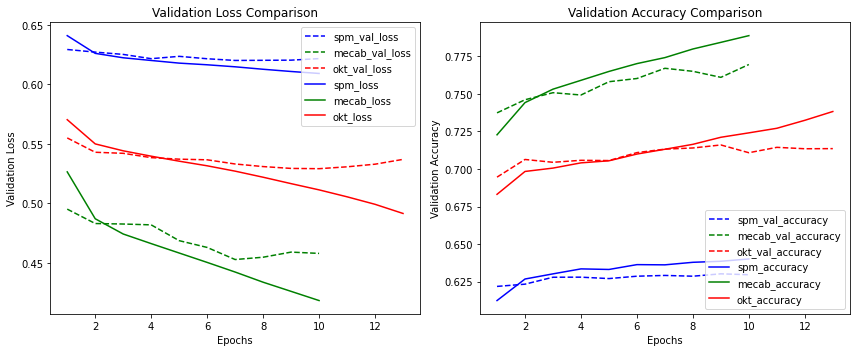

In [111]:
import matplotlib.pyplot as plt

# 모델 히스토리에서 'val_loss'와 'val_accuracy' 값 추출
model1_history = history_spm.history
model2_history = history_mecab.history
model3_history = history_okt.history

# epoch 수 (x축) 생성
epochs_model1 = range(1, len(model1_history['val_loss']) + 1)
epochs_model2 = range(1, len(model2_history['val_loss']) + 1)
epochs_model3 = range(1, len(model3_history['val_loss']) + 1)

# 그래프 크기 설정
plt.figure(figsize=(12, 5))

# 첫 번째 subplot: Validation Loss
plt.subplot(1, 2, 1)
plt.plot(epochs_model1, model1_history['val_loss'], '--b', label='spm_val_loss')
plt.plot(epochs_model2, model2_history['val_loss'], '--g', label='mecab_val_loss')
plt.plot(epochs_model3, model3_history['val_loss'], '--r', label='okt_val_loss')
plt.plot(epochs_model1, model1_history['loss'], 'b', label='spm_loss')
plt.plot(epochs_model2, model2_history['loss'], 'g', label='mecab_loss')
plt.plot(epochs_model3, model3_history['loss'], 'r', label='okt_loss')
plt.title('Validation Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.legend()

# 두 번째 subplot: Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_model1, model1_history['val_acc'], '--b', label='spm_val_accuracy')
plt.plot(epochs_model2, model2_history['val_acc'], '--g', label='mecab_val_accuracy')
plt.plot(epochs_model3, model3_history['val_acc'], '--r', label='okt_val_accuracy')
plt.plot(epochs_model1, model1_history['acc'], 'b', label='spm_accuracy')
plt.plot(epochs_model2, model2_history['acc'], 'g', label='mecab_accuracy')
plt.plot(epochs_model3, model3_history['acc'], 'r', label='okt_accuracy')
plt.title('Validation Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.legend()

# 그래프 보여주기
plt.tight_layout()
plt.show()
